### Duel output UNet on pennate diatoms - testing accuracy
### Rayna Hamilton
### March 27, 2025

We will have trained a UNet neural network to detect the locations of pennate diatom cells in strained microscopy images in train_unet.ipynb.  Let's see how well this network functions on images it has and has not seen before.

In [1]:
# U-NET CNN Approach to Automated Image Analysis
    # base code from: https://www.kaggle.com/code/vbookshelf/simple-cell-segmentation-with-keras-and-u-net
#-------------------------------------------------------------------------------------------------------------

# Read in libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
# %matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
# warnings.filterwarnings('ignore')

IMG_TILE_SIZE=400
IMG_CHANNELS = 3 # RGB


In [2]:
# Read in data
mother_directory = "../../data/train_images/" 
    # home of analyzed output images & csvs

# get a list of files in each folder
mask_dir = "../../data/binary_masks/train/"

img_list = os.listdir(mother_directory)
img_list=[val for val in img_list if val.endswith(".jpg")]
mask_list = os.listdir(mask_dir)
mask_list=[val for val in mask_list if val.endswith(".jpg")]

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])


The training data labels are termed binary masks, meaning that all pixels in the image are either 1 (cell) or 0 (non-cell).  Currently, I have more cell body annotations than cell outline annotations, but hopefully we will have more annotations of both for subsequent runs.

In [3]:
# ================================================
# Add a column indicating if an image has a mask for outline and cell contents
# ================================================

def check_for_mask(x):
    x=x.replace(".jpg",".jpg")
    if x in [val.replace("_masks","") for val in somelist]:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
somelist=mask_list
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)


In [4]:

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = [val for val in df_masks['image_id']]

df_masks.shape

C:\Users\Rayna\AppData\Local\Temp\ipykernel_146656\3158210854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masks['mask_id'] = [val for val in df_masks['image_id']]


(24, 3)

In [5]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
# Create empty arrays

X = np.zeros((len(image_id_list), 1040,1388,3), dtype=np.uint8)
y = np.zeros((len(image_id_list), 1040,1388), dtype=bool)
# X_train


for i, image_id in enumerate(image_id_list):
    path_image = mother_directory + image_id
    # read the image using skimage
    image = imread(path_image)
    X[i] = image
    
X.shape

(24, 1040, 1388, 3)

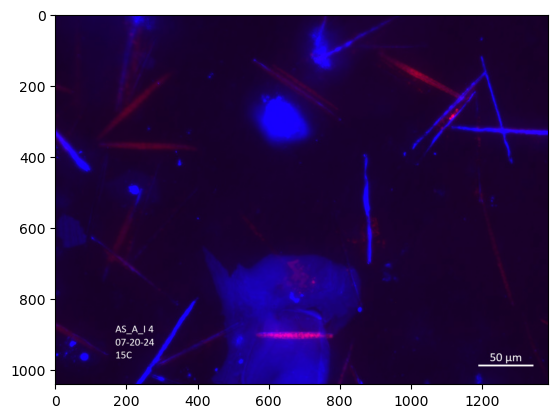

In [6]:
plt.imshow(X[0])

In the above sample image, blue lines are late-stage infected cells, and red lines are healthy cells.

In [10]:
y_cell=[]
for i, mask_id in enumerate(mask_id_list):
    
    path_mask =mask_dir + mask_id
    # read the image using skimage
    mask = imread(path_mask)[:,:,0]
    y_cell.append(mask)
y_cell=np.array(y_cell)
y_cell.shape

(24, 1040, 1388)

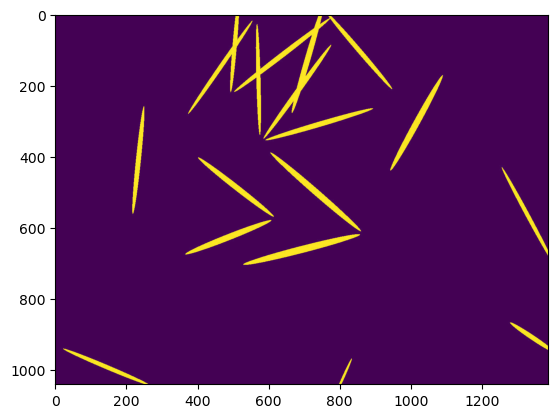

In [11]:
plt.imshow(y_cell[14])

The network was trained on 400-by-400 overlapping slices of the above larger images, and as such we must give it data of this shape to get predictions.  I initially was expecting to have to average the output of multiple overlapping slices of the test set predictions, but the network ends up doing well enough at the edges of image slices that this did not end up being necessary.  As such, we will just split up the input images into adjacent 400-by-400 tiles, with some overlap in the last tiles as the image dimensions are not divisible by 400.

In [12]:
def split_input_image(X):
    tiled_x_cell=[]
    max_x,max_y=1040,1388
    for i in range(len(X)):
        tiled_x_cell.append([])
        for y_pos in [0,400,800,1200]:
            for x_pos in [0,400,800]:
                image_slice=np.zeros((400,400,3), dtype=np.uint8)
                x_range=min(400,max_x-x_pos)
                y_range=min(400,max_y-y_pos)
                if x_range==400:
                    if y_range==400:
                        image_slice=X[i,x_pos:x_pos+400,y_pos:y_pos+400]
                    else:
                        image_slice=X[i,x_pos:x_pos+400,max_y-400:max_y]
                else:
                    if y_range==400:
                        image_slice=X[i,max_x-400:max_x,y_pos:y_pos+400]
                    else:
                        image_slice=X[i,max_x-400:max_x,max_y-400:max_y]
                tiled_x_cell[-1].append(image_slice)
    return tiled_x_cell

Text(0.5, 1.0, 'Initial training image')

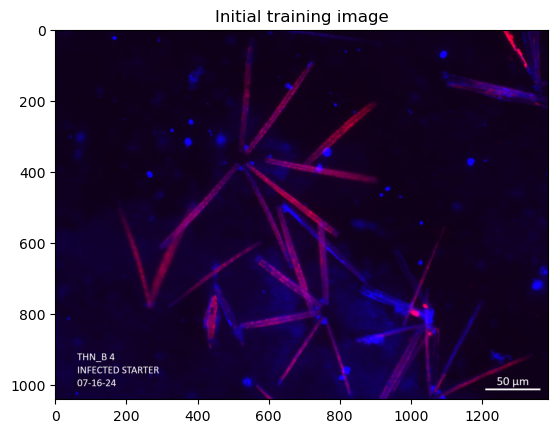

In [13]:
plt.imshow(X[-1])
plt.title("Initial training image")

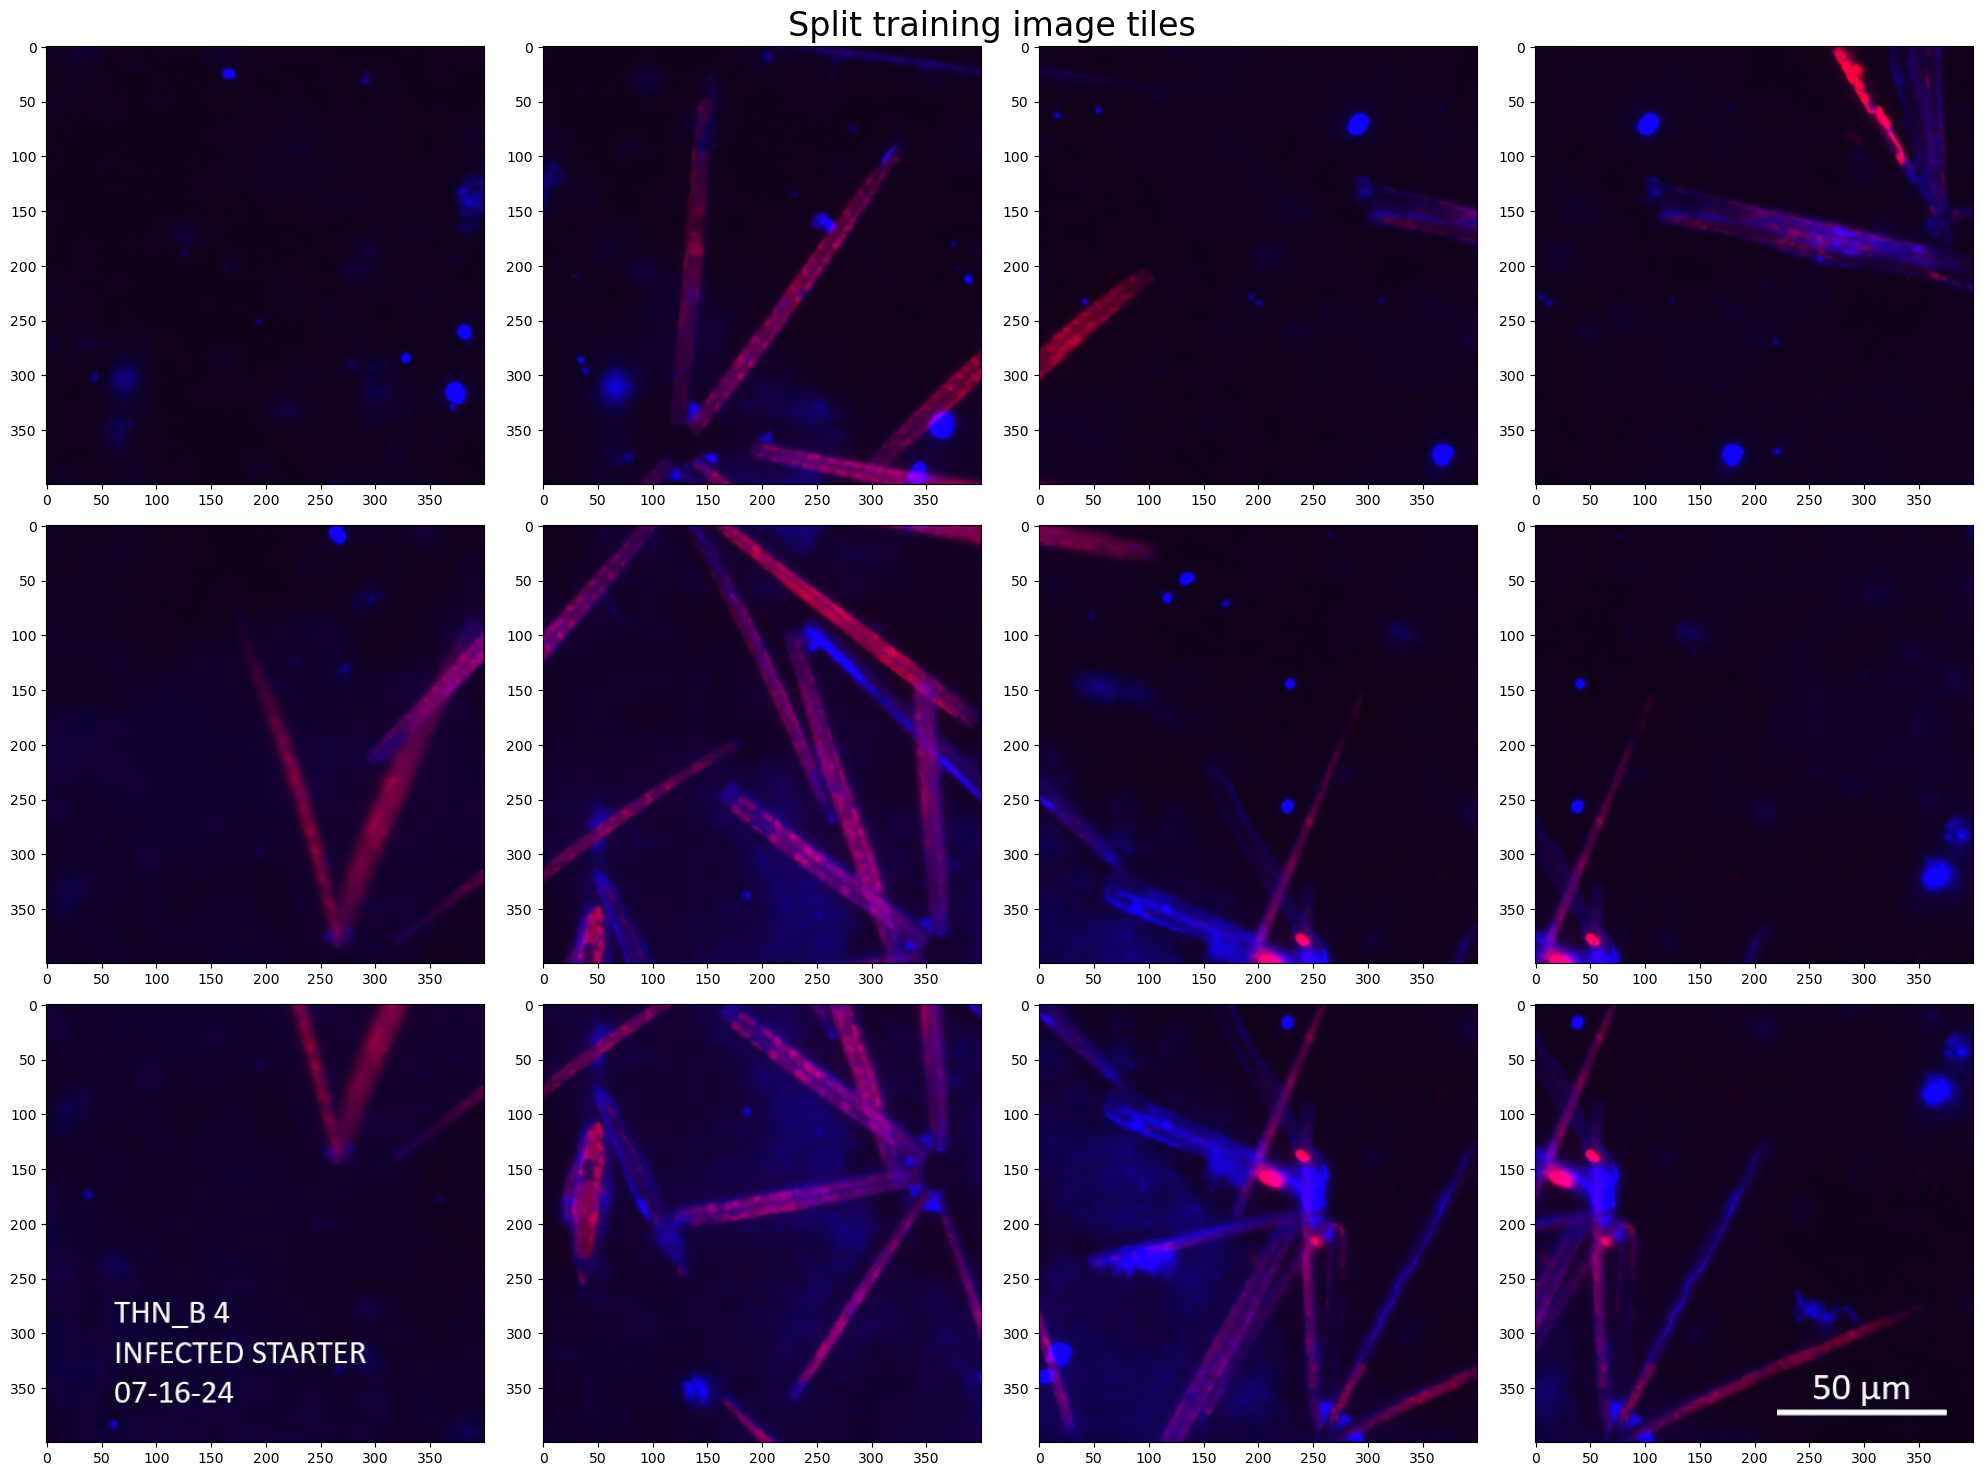

In [14]:
#make sure these are ordered correctly
fig, ax = plt.subplots(3,4, figsize=(20, 15))
tiled_x_cell=split_input_image(X)
for i in range(0,12):
    ax[i%3,int(i/3)].imshow(tiled_x_cell[-1][i])
fig.suptitle("Split training image tiles",fontsize=24)
fig.tight_layout()

The split images look as we would expect, with overlap in the far right and bottom tiles.  Now we can feed these slices into our network to determine accuracy.

In [15]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


In [16]:
IMG_CHANNELS=3
inputs = Input((400,400, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy',loss_weights=[1,1000])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

We must normalize our y data, which currently ranges from 0 to 255, to range from 0 to 1, as otherwise we will encounter issues in loss function calculation.

In [17]:
y_cell=y_cell/255
y_cell[y_cell>0]=1

In [18]:
model.load_weights('models/cell_model.h5')

In [19]:
train_predictions=[]
for i in range(len(tiled_x_cell)):
    train_predictions.append(model.predict(np.array(tiled_x_cell[i])))

1/1 [==============================] - 0s 310ms/step


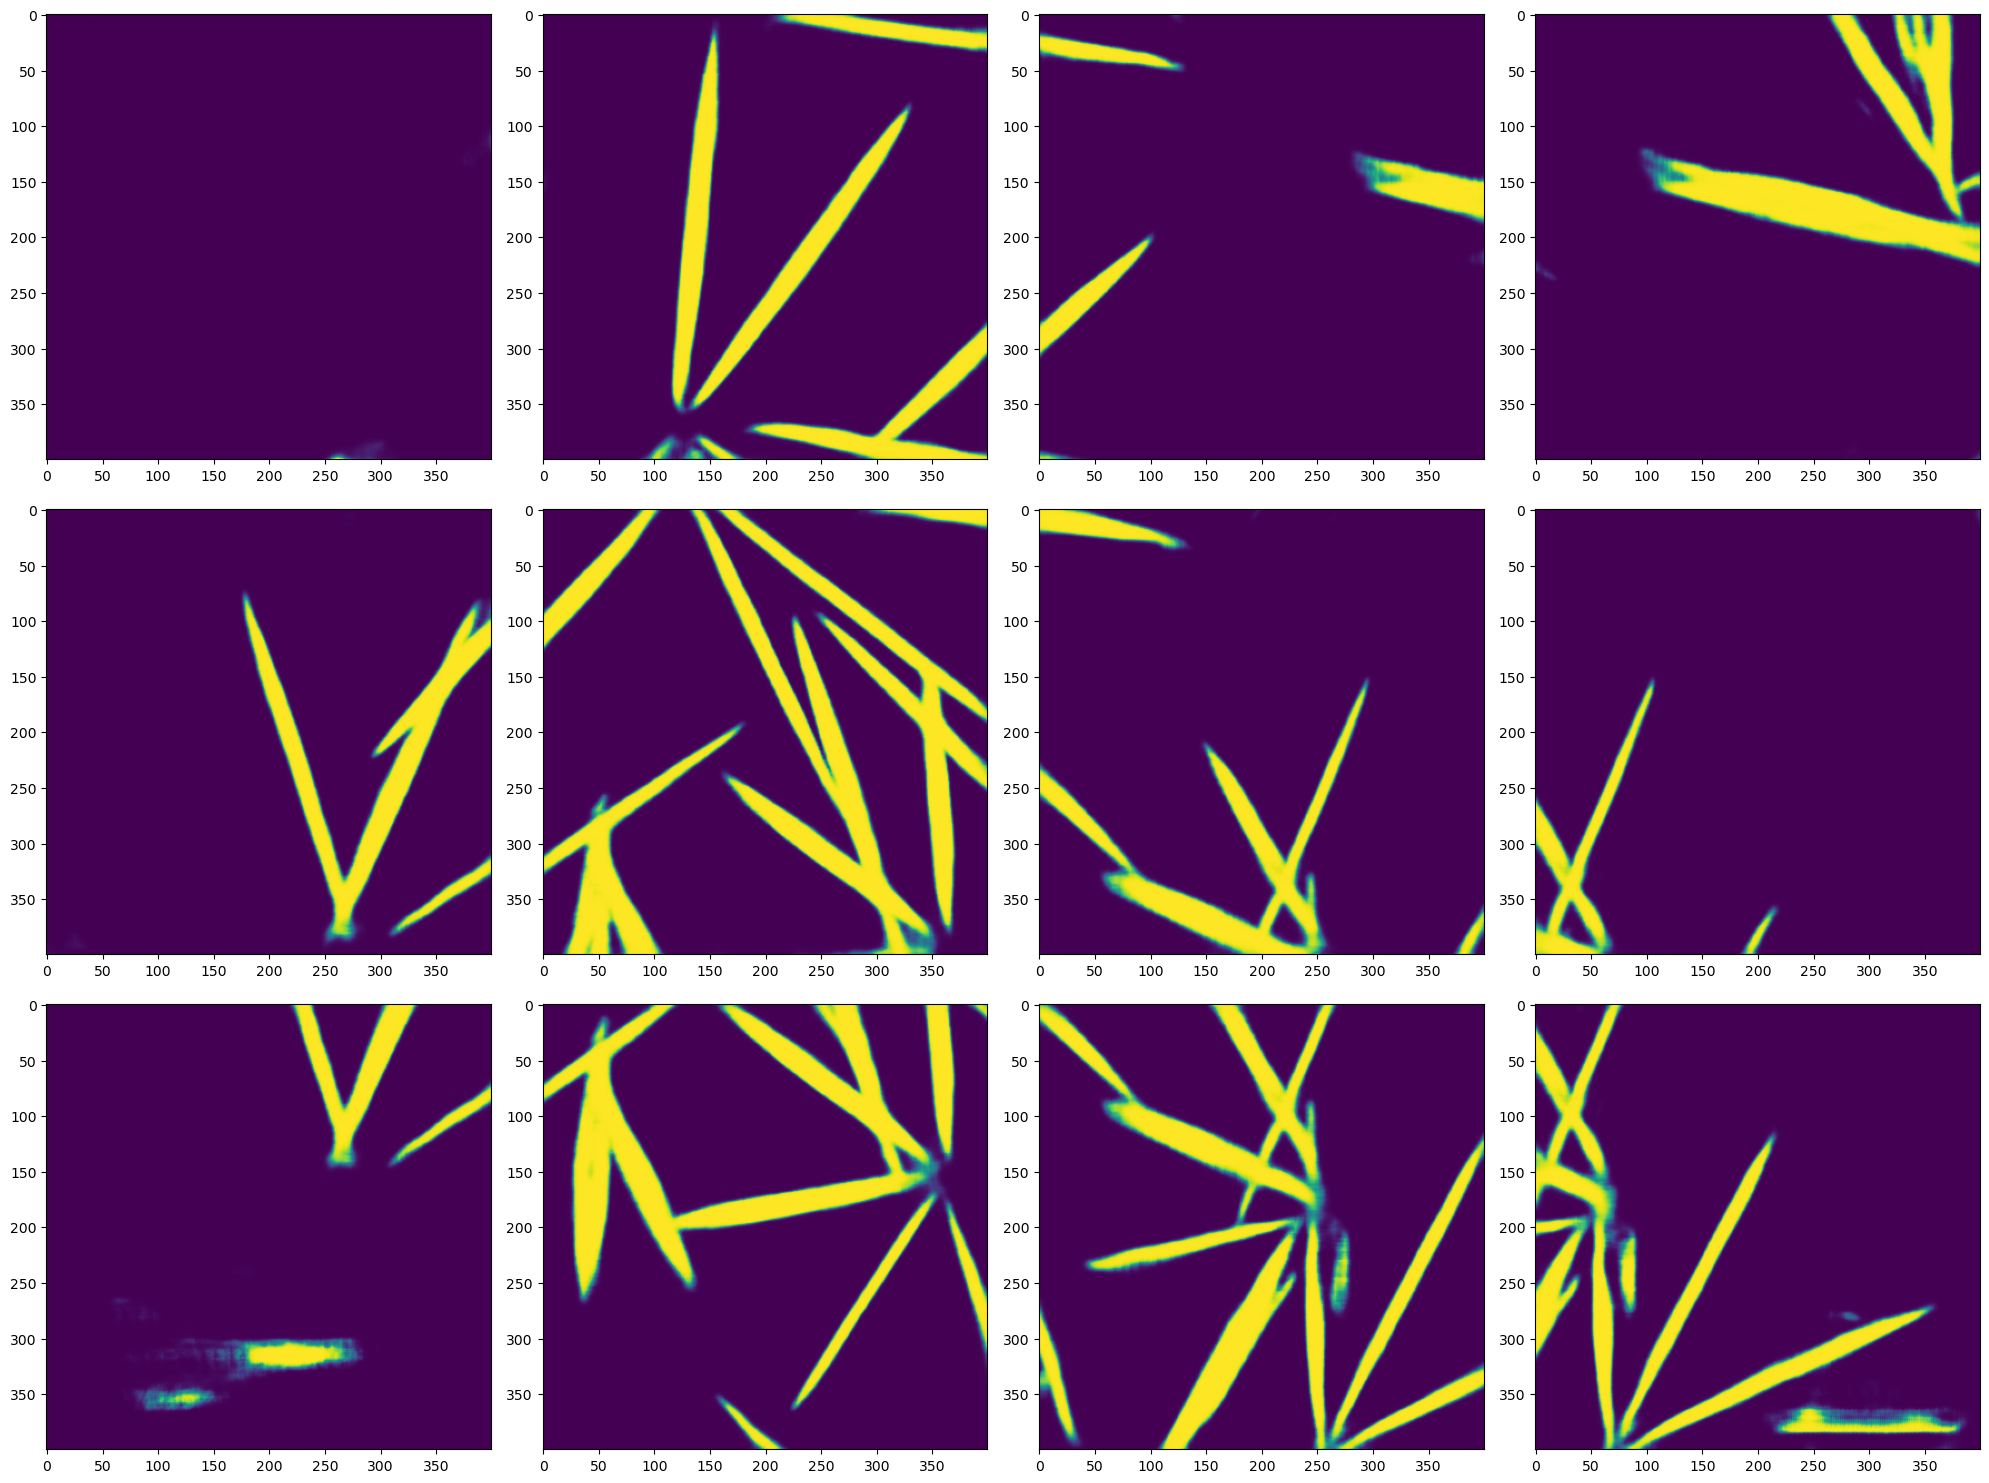

In [20]:
fig, ax = plt.subplots(3,4, figsize=(20, 15))

for i in range(0,12):
    ax[i%3,int(i/3)].imshow(train_predictions[-1][i])
fig.tight_layout()

The output predictions are in tiles, which we can now merge back into a single image.

In [25]:
def join_prediction_tiles(prediction_tiles):
    #get predictions back into a single np array per image
    max_x,max_y=1040,1388
    single_prediction=np.zeros((1040,1388,1),dtype=np.float64)
    for i in range(len(prediction_tiles)):
        if i%3*400+400<max_x and int(i/3)*400+400<max_y:
            single_prediction[i%3*400:i%3*400+400,int(i/3)*400:int(i/3)*400+400,:]=prediction_tiles[i]
        elif i%3*400+400<max_x and int(i/3)*400+400>max_y:
            single_prediction[i%3*400:i%3*400+400,int(i/3)*400:max_y,:]=prediction_tiles[i][:,400-(max_y-int(i/3)*400):]
        elif i%3*400+400>max_x and int(i/3)*400+400<max_y:
            single_prediction[i%3*400:max_x,int(i/3)*400:int(i/3)*400+400,:]=prediction_tiles[i][400-(max_x-i%3*400):,:]
        else:
            single_prediction[i%3*400:max_x,int(i/3)*400:max_y,:]=prediction_tiles[i][400-(max_x-i%3*400):,400-(max_y-int(i/3)*400):,:]
    return (single_prediction>0.5)[:,:,0]

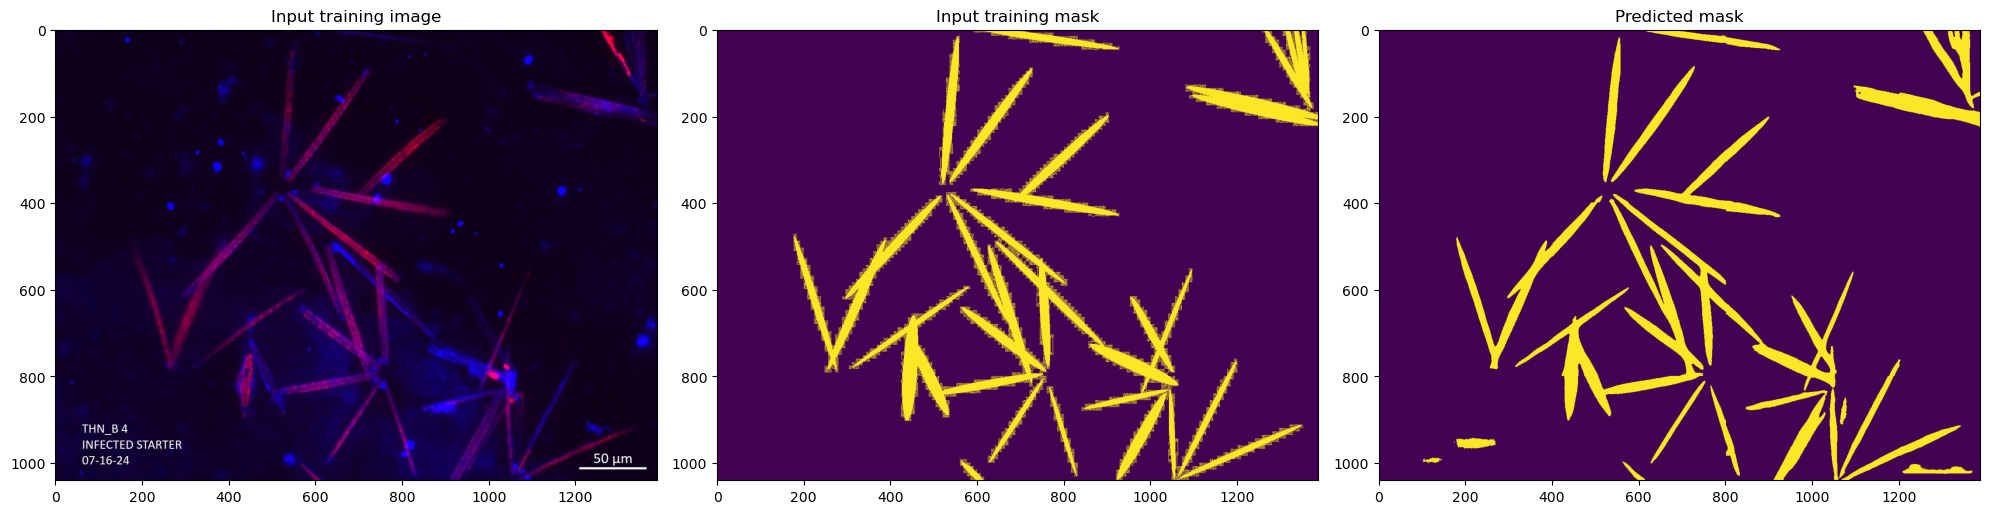

In [26]:
single_prediction=join_prediction_tiles(train_predictions[-1])
fig, ax = plt.subplots(1,3, figsize=(20, 8))
ax[0].imshow(X[-1])
ax[1].imshow(y_cell[-1])
ax[2].imshow(single_prediction)
ax[0].set_title("Input training image")
ax[1].set_title("Input training mask")
ax[2].set_title("Predicted mask")
fig.tight_layout()

Now we can apply this join operation to the rest of the training dataset and get our training accuracy.

In [27]:
def dice_score(mask1, mask2):
    intersection = np.sum(mask1*mask2)
    sum1=np.sum(mask1)
    sum2=np.sum(mask2)
    dice= np.mean(2*intersection/(sum1+sum2))
    return dice    

def accuracy_score(mask1,mask2):
    return np.sum(mask1==mask2)/(1388*1040)

In [28]:
joined_predictions=[]
for j in range(len(X)):
    joined_predictions.append(join_prediction_tiles(train_predictions[j]))
train_predictions=joined_predictions

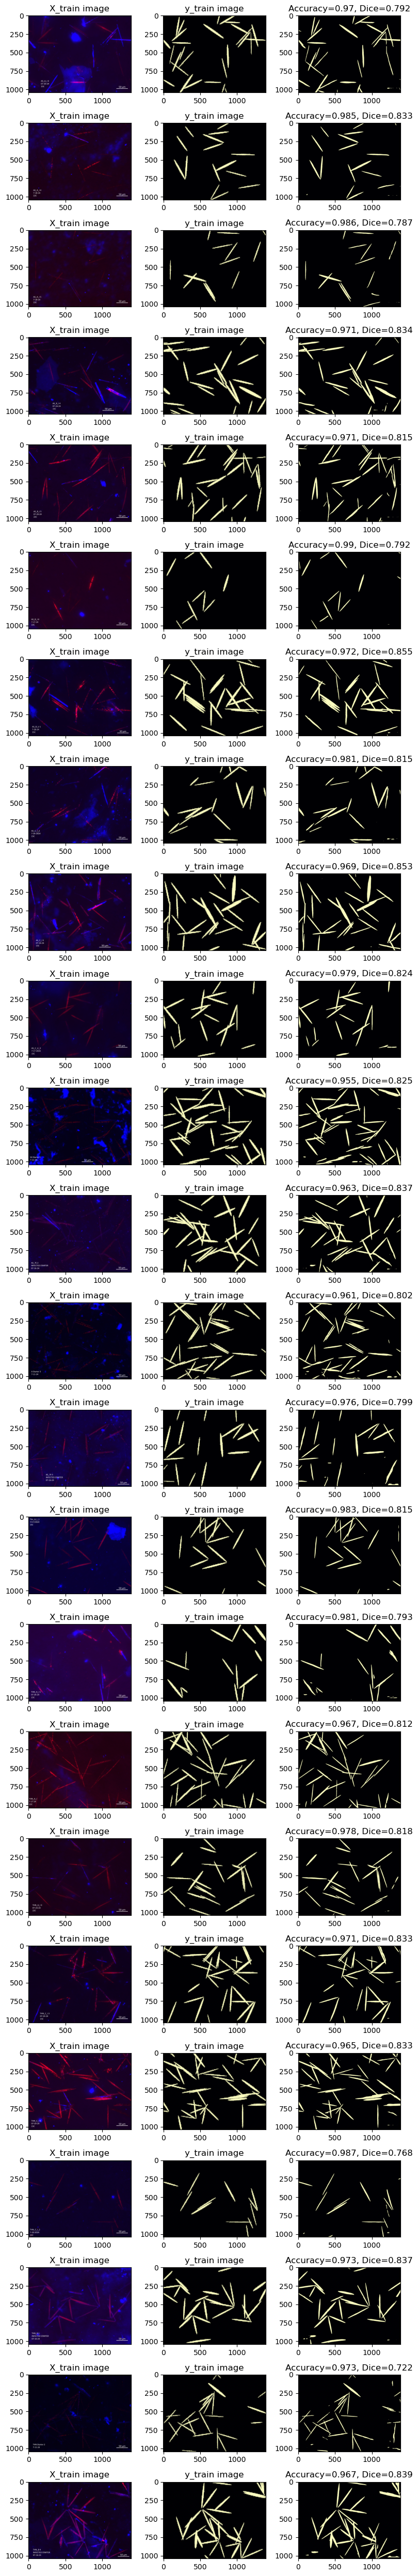

In [29]:
accuracies,dice_scores=[],[]
fig, ax = plt.subplots(24, 3, figsize=(8, 50))
for i in range(len(X)):
    accuracies.append(accuracy_score(y_cell[i],train_predictions[i]))
    dice_scores.append(dice_score(y_cell[i],train_predictions[i]))
    ax[i,0].imshow(X[i], cmap='magma')
    ax[i,1].imshow(y_cell[i], cmap='magma')
    ax[i,2].imshow(train_predictions[i], cmap='magma')
    ax[i,0].set_title("X_train image")
    ax[i,1].set_title("y_train image")
    ax[i,2].set_title("Accuracy="+str(round(accuracies[-1],3))+", Dice="+str(round(dice_scores[-1],3)))
fig.tight_layout()

In [30]:
print(f"The model attains a mean training accuracy of {round(np.mean(accuracies),3)} and a mean training dice score of {round(np.mean(dice_scores),3)}.")

The model attains a mean training accuracy of 0.974 and a mean training dice score of 0.814.


Now let's check out the accuracy on some newly annotated test images.

In [33]:
# Read in data
mother_directory = "../../data/test_images/" 
    # home of analyzed output images & csvs
child_directory_image = "ML_output/images/"
child_directory_csv = "ML_output/csvs/"

# get a list of files in each folder
mask_dir = "../../data/binary_masks/test/"

img_list = os.listdir(mother_directory)
img_list=[val for val in img_list if val.endswith(".jpg")]
mask_list = os.listdir(mask_dir)
mask_list=[val for val in mask_list if val.endswith(".jpg")]

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])


In [34]:

def check_for_mask(x):
    x=x.replace(".jpg",".jpg")
    if x in [val.replace("_masks","") for val in somelist]:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
somelist=mask_list
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = [val for val in df_masks['image_id']]

df_masks.shape

C:\Users\Rayna\AppData\Local\Temp\ipykernel_146656\2610601284.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masks['mask_id'] = [val for val in df_masks['image_id']]


(6, 3)

In [35]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
# Create empty arrays

X = np.zeros((len(image_id_list), 1040,1388,3), dtype=np.uint8)
y = np.zeros((len(image_id_list), 1040,1388), dtype=bool)
# X_train


for i, image_id in enumerate(image_id_list):
    path_image = mother_directory + image_id
    # read the image using skimage
    image = imread(path_image)
    X[i] = image
    
X.shape

(6, 1040, 1388, 3)

In [36]:
y_cell=[]
for i, mask_id in enumerate(mask_id_list):
    
    path_mask =mask_dir + mask_id
    # read the image using skimage
    mask = imread(path_mask)[:,:,0]
    y_cell.append(mask)
y_cell,y_outline=np.array(y_cell),np.array(y_outline)
y_cell.shape

(6, 1040, 1388)

In [37]:
tiled_x_cell=split_input_image(X)
test_predictions=[]
for i in range(len(tiled_x_cell)):
    test_predictions.append(model.predict(np.array(tiled_x_cell[i])))

1/1 [==============================] - 0s 310ms/step


In [38]:
y_cell=y_cell/255
y_cell[y_cell>0]=1

In [39]:
joined_predictions=[]
for j in range(len(X)):
    joined_predictions.append(join_prediction_tiles(test_predictions[j]))
test_predictions=joined_predictions

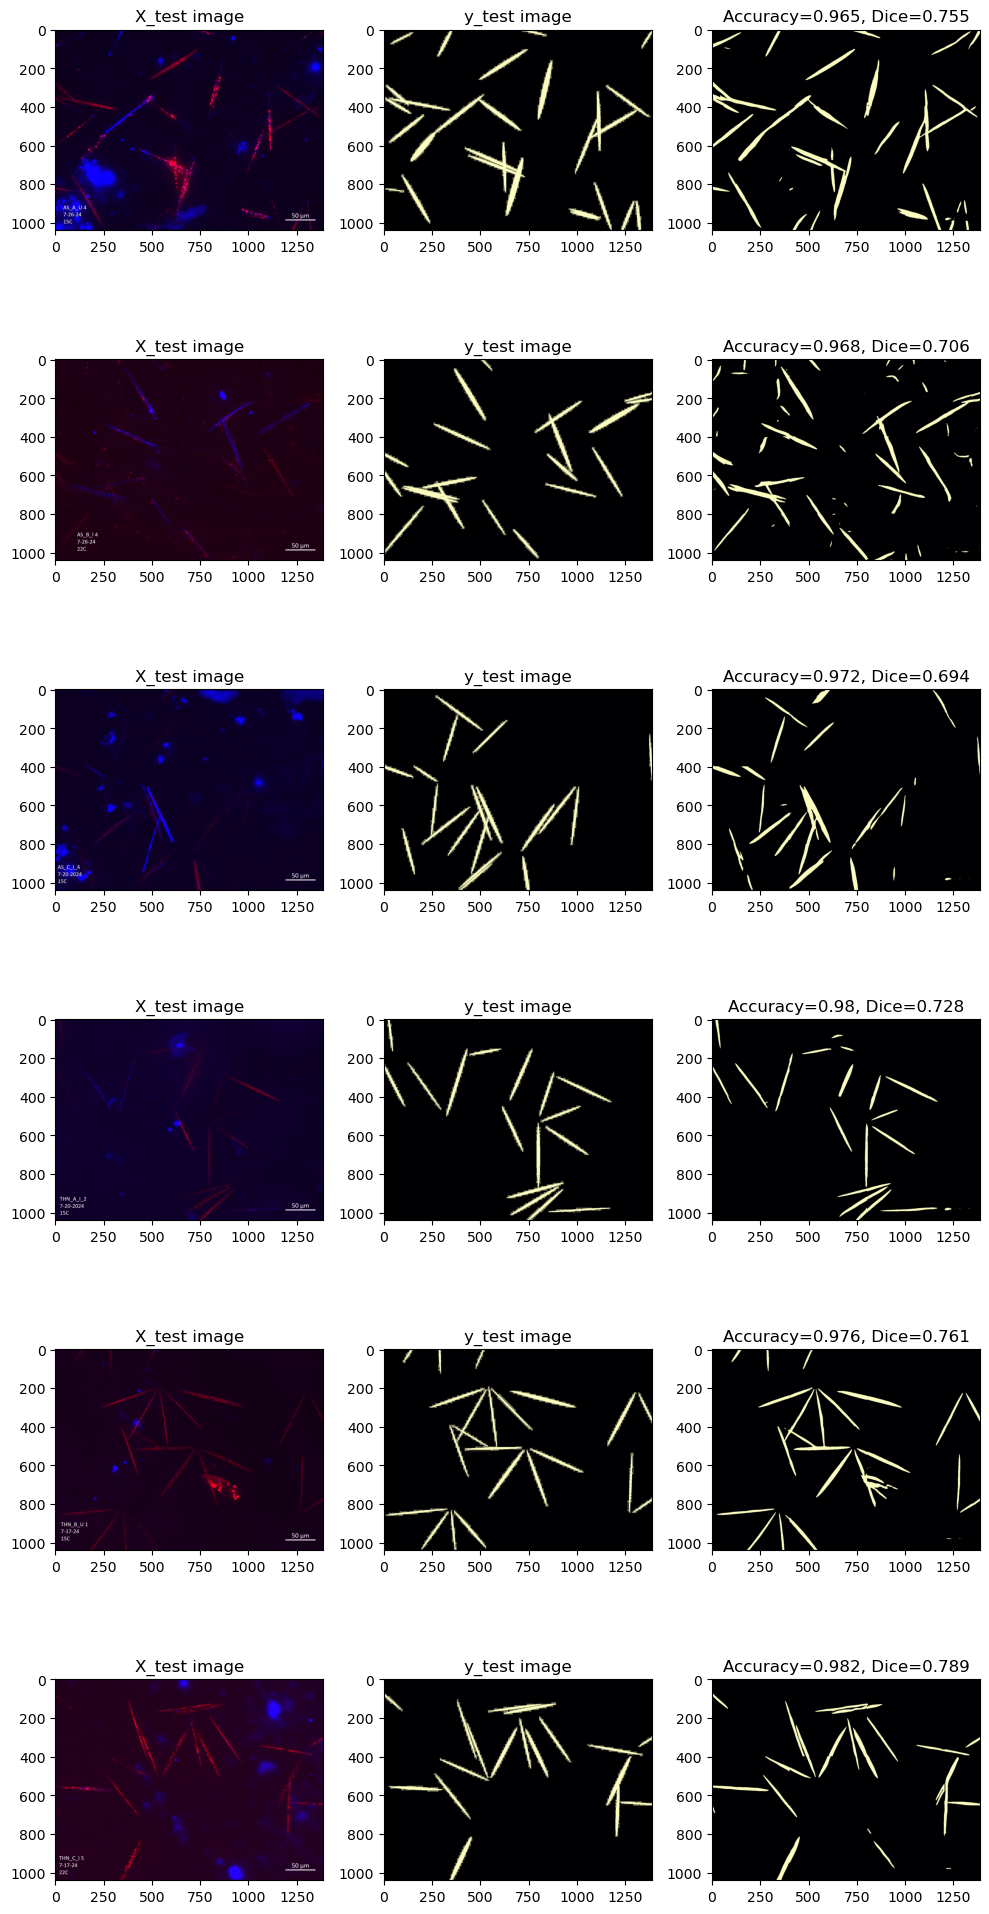

In [86]:
accuracies,dice_scores=[],[]
fig, ax = plt.subplots(6, 3, figsize=(10,20))
for i in range(len(X)):
    accuracies.append(accuracy_score(y_cell[i],test_predictions[i]))
    dice_scores.append(dice_score(y_cell[i],test_predictions[i]))
    ax[i,0].imshow(X[i], cmap='magma')
    ax[i,1].imshow(y_cell[i], cmap='magma')
    ax[i,2].imshow(test_predictions[i], cmap='magma')
    ax[i,0].set_title("X_test image")
    ax[i,1].set_title("y_test image")
    ax[i,2].set_title("Accuracy="+str(round(accuracies[-1],3))+", Dice="+str(round(dice_scores[-1],3)))
fig.tight_layout()

In [87]:
fig.savefig("ML_output/test_set_segmentation_example.png")

In [41]:
print(f"The model attains a mean testing accuracy of {round(np.mean(accuracies),3)} and a mean training dice score of {round(np.mean(dice_scores),3)}.")

The model attains a mean testing accuracy of 0.974 and a mean training dice score of 0.739.


Let's briefly look at a function to split predictions into individual "blobs" - that is, connected regions of filled-in pixels.  This function operates by scanning along a prediction until it finds a non-zero pixel and, if this pixel is not in its list of previously found pixels, it expands outwards in all directions until no more filled-in pixels are found. Note that at this point since I have not yet implemented the cell outline prediction, intersecting and overlapping cells will still be considered part of the same blob.

In [42]:
def find_blobs(array):
    segmented_cells=np.zeros((1040,1388,3), dtype=np.uint8)
    coordinates_to_blobs=dict()
    current_blob=-1
    clean_array=np.copy(array)
    blob_sizes=[]
    for i in range(0,len(array)):
        for j in range(0,len(array[i])):    
            if array[i,j]==1 and f"{i},{j}" not in coordinates_to_blobs.keys():
                red,green,blue=np.random.randint(50,255),np.random.randint(50,255),np.random.randint(50,255)
                #start a new blob
                current_blob+=1
                coordinates_to_check=[f"{i},{j}"]
                x,y=i,j
                #print(f"Starting new blob {current_blob}.")
                while True:#expand outwards from current pixel position in all directions until no more filled coordinates are found
                    segmented_cells[x,y,0]=red
                    segmented_cells[x,y,1]=green
                    segmented_cells[x,y,2]=blue
                    coordinates_to_blobs[f"{x},{y}"]=current_blob
                    #check all four surrounding pixels
                    if x>0 and array[x-1,y]>0 and f"{x-1},{y}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x-1},{y}")
                    if x<len(array)-1 and array[x+1,y]>0 and f"{x+1},{y}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x+1},{y}")
                    if y>0 and array[x,y-1]>0 and f"{x},{y-1}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x},{y-1}")
                    if y<len(array[0])-1 and array[x,y+1]>0 and f"{x},{y+1}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x},{y+1}")
                    x=int(coordinates_to_check[-1].split(",")[0])
                    y=int(coordinates_to_check[-1].split(",")[1])
                    coordinates_to_check=coordinates_to_check[:-1]
                    if len(coordinates_to_check)==0:
                        #print(f"Blob {current_blob} has pixel size {sum([val==current_blob for val in list(coordinates_to_blobs.values())])}")
                        blob_sizes.append(sum([val==current_blob for val in list(coordinates_to_blobs.values())]))
                        break
    plt.imshow(segmented_cells)
    return coordinates_to_blobs,blob_sizes
       

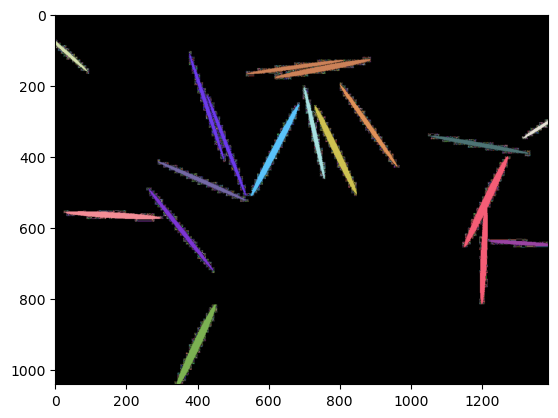

In [43]:
all_blob_sizes=[]
for img in y_cell:
    coordinates_to_blobs,blob_sizes=find_blobs(img)
    all_blob_sizes=all_blob_sizes+blob_sizes

Above is a sample for one of the y binary masks of what is considered a separate blob.  Since the model sometimes has very small regions passing the confidence threshold that are not large enough to be considered a cell, let's decide on a minimum blob size to consider as a cell.

(array([16.,  3.,  6.,  3.,  6.,  6.,  7., 15.,  9.,  7.,  2.,  5.,  4.,
         1.,  2.,  0.,  4.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   23.  ,   398.36,   773.72,  1149.08,  1524.44,  1899.8 ,
         2275.16,  2650.52,  3025.88,  3401.24,  3776.6 ,  4151.96,
         4527.32,  4902.68,  5278.04,  5653.4 ,  6028.76,  6404.12,
         6779.48,  7154.84,  7530.2 ,  7905.56,  8280.92,  8656.28,
         9031.64,  9407.  ,  9782.36, 10157.72, 10533.08, 10908.44,
        11283.8 , 11659.16, 12034.52, 12409.88, 12785.24, 13160.6 ,
        13535.96, 13911.32, 14286.68, 14662.04, 15037.4 , 15412.76,
        15788.12, 16163.48, 16538.84, 16914.2 , 17289.56, 17664.92,
        18040.28, 18415.64, 18791.  ]),
 <BarContainer object of 50 artists>)

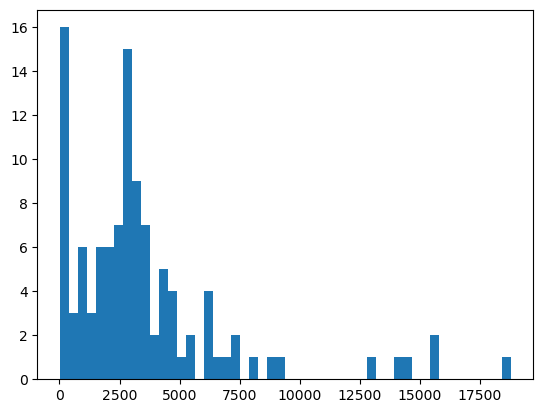

In [60]:
plt.hist([val for val in all_blob_sizes if val>20],bins=50)

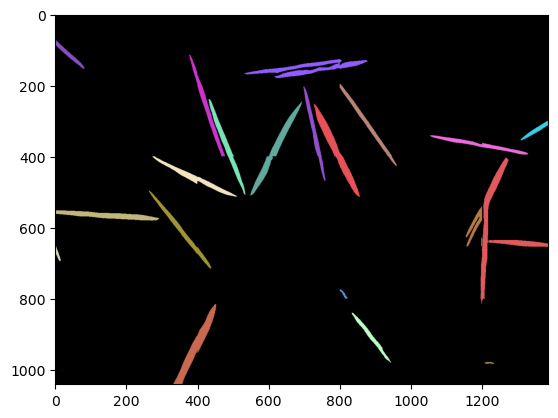

In [62]:
#for comparison, the y predictions
all_blob_sizes=[]
for img in test_predictions:
    coordinates_to_blobs,blob_sizes=find_blobs(img)
    all_blob_sizes=all_blob_sizes+blob_sizes

(array([96., 19.,  7.,  7., 10.,  6.,  6.,  8., 12., 13.,  7.,  5.,  5.,
         1.,  3.,  3.,  3.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.]),
 array([1.000000e+00, 3.180600e+02, 6.351200e+02, 9.521800e+02,
        1.269240e+03, 1.586300e+03, 1.903360e+03, 2.220420e+03,
        2.537480e+03, 2.854540e+03, 3.171600e+03, 3.488660e+03,
        3.805720e+03, 4.122780e+03, 4.439840e+03, 4.756900e+03,
        5.073960e+03, 5.391020e+03, 5.708080e+03, 6.025140e+03,
        6.342200e+03, 6.659260e+03, 6.976320e+03, 7.293380e+03,
        7.610440e+03, 7.927500e+03, 8.244560e+03, 8.561620e+03,
        8.878680e+03, 9.195740e+03, 9.512800e+03, 9.829860e+03,
        1.014692e+04, 1.046398e+04, 1.078104e+04, 1.109810e+04,
        1.141516e+04, 1.173222e+04, 1.204928e+04, 1.236634e+04,
        1.268340e+04, 1.300046e+04, 1.331752e+04, 1.363458e+04,
        1.39

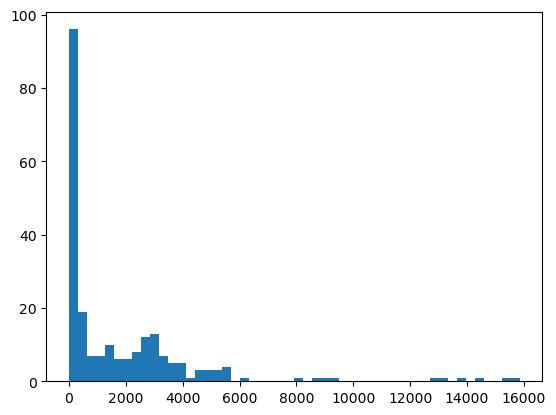

In [65]:
plt.hist(all_blob_sizes,bins=50)

Unfortunately just reading in the binary masks and converting them to binary results in some orphaned edge pixels with very small blob sizes.  But based on the distribution I am going to set a minimum blob size of 700 to be considered a cell.

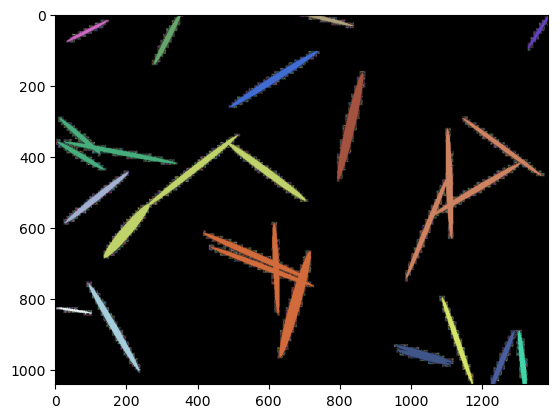

In [66]:
def remove_tiny_blobs(array,min_size=700):
    segmented_cells=np.zeros((1040,1388,3), dtype=np.uint8)
    clean_predictions=np.zeros((1040,1388), dtype=np.uint8)
    coordinates_to_blobs=dict()
    current_blob=-1
    clean_array=np.copy(array)
    blob_sizes=[]
    for i in range(0,len(array)):
        for j in range(0,len(array[i])):    
            if array[i,j]==1 and f"{i},{j}" not in coordinates_to_blobs.keys():
                red,green,blue=np.random.randint(50,255),np.random.randint(50,255),np.random.randint(50,255)
                #start a new blob
                current_blob+=1
                coordinates_to_check=[f"{i},{j}"]
                x,y=i,j
                while True:#expand outwards from current pixel position in all directions until no more filled coordinates are found
                    segmented_cells[x,y,0]=red
                    segmented_cells[x,y,1]=green
                    segmented_cells[x,y,2]=blue
                    coordinates_to_blobs[f"{x},{y}"]=current_blob
                    #check all four surrounding pixels
                    if x>0 and array[x-1,y]>0 and f"{x-1},{y}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x-1},{y}")
                    if x<len(array)-1 and array[x+1,y]>0 and f"{x+1},{y}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x+1},{y}")
                    if y>0 and array[x,y-1]>0 and f"{x},{y-1}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x},{y-1}")
                    if y<len(array[0])-1 and array[x,y+1]>0 and f"{x},{y+1}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x},{y+1}")
                    x=int(coordinates_to_check[-1].split(",")[0])
                    y=int(coordinates_to_check[-1].split(",")[1])
                    coordinates_to_check=coordinates_to_check[:-1]
                    if len(coordinates_to_check)==0:
                        blob_sizes.append(sum([val==current_blob for val in list(coordinates_to_blobs.values())]))
                        break
    for coordinate_pair,current_blob in coordinates_to_blobs.items():
        if blob_sizes[current_blob]>=min_size:
            x=int(coordinate_pair.split(",")[0])
            y=int(coordinate_pair.split(",")[1])
            clean_predictions[x,y]=1
    plt.imshow(segmented_cells)
    return coordinates_to_blobs,blob_sizes,clean_predictions


coordinates_to_blobs,blob_sizes,clean_prediction=remove_tiny_blobs(y_cell[0])    

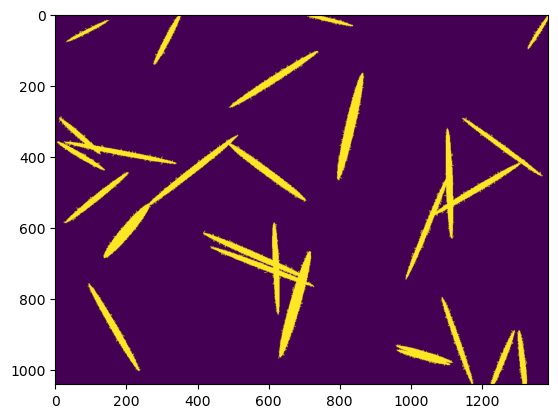

In [74]:
plt.imshow(clean_prediction)

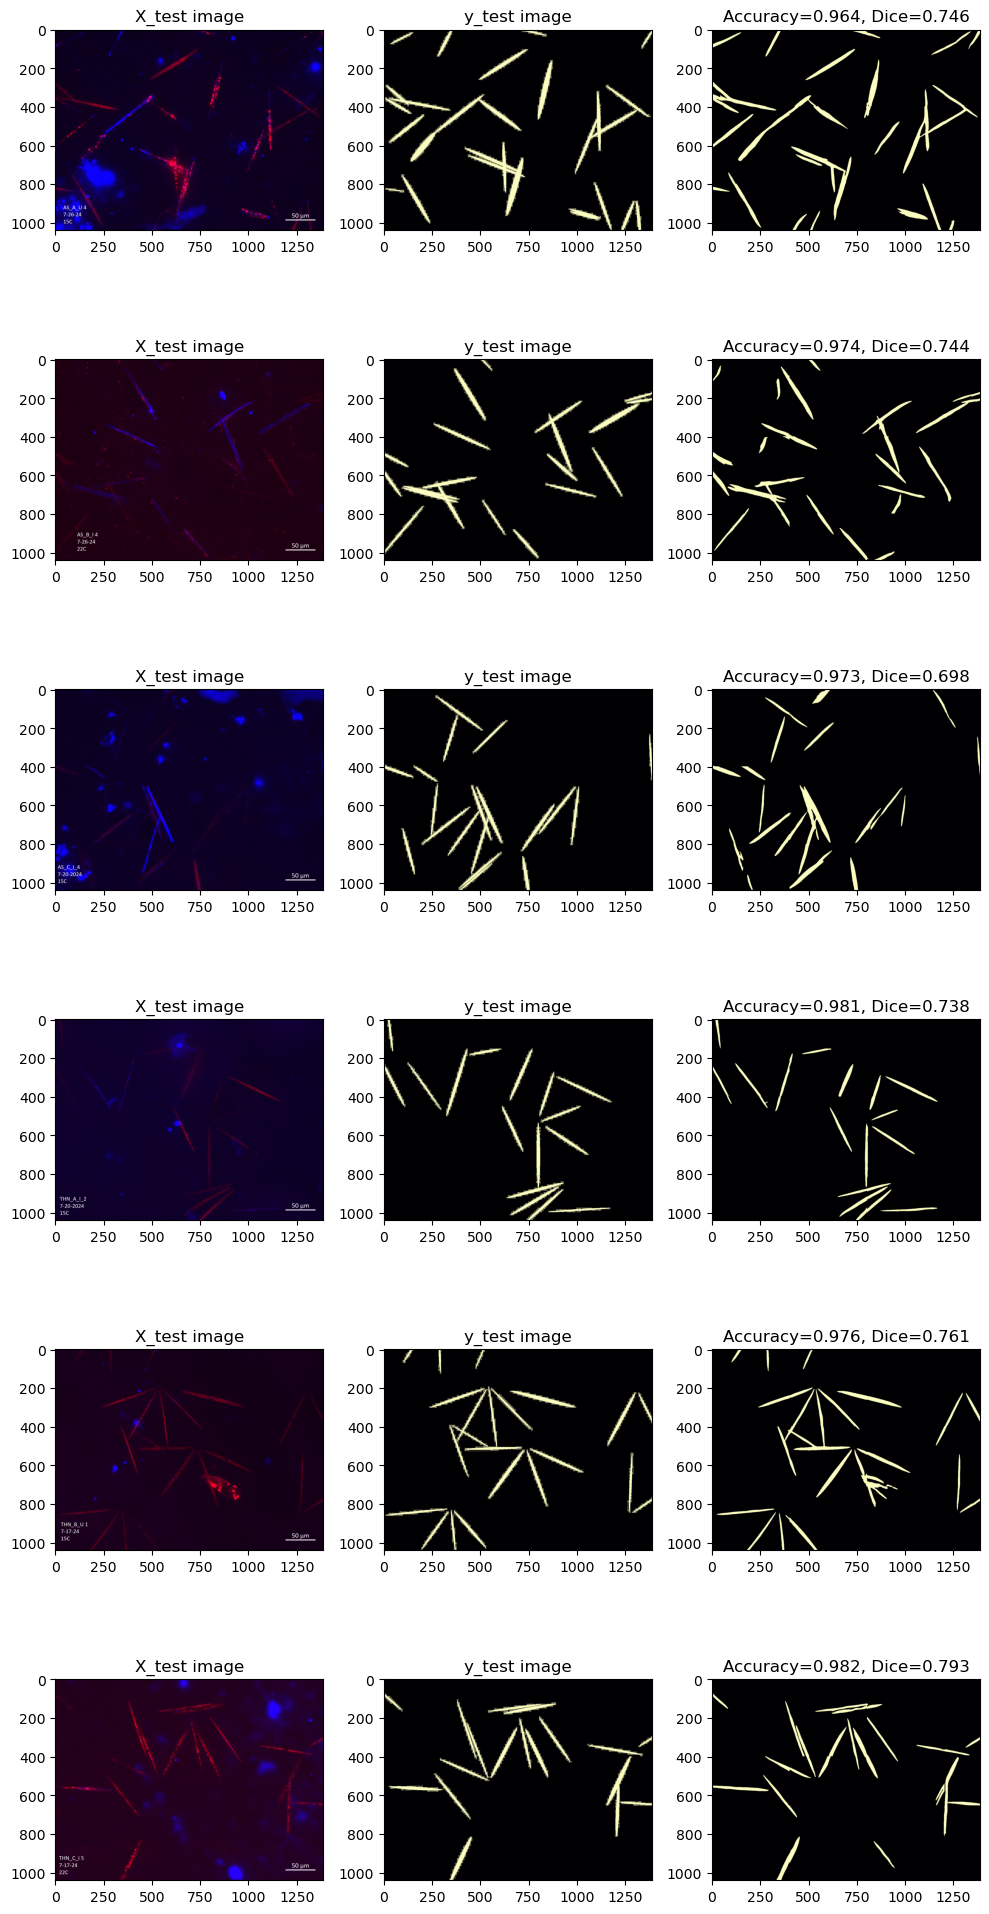

In [90]:
#see how accuracy and dice score changes when removing tiny blobs
accuracies,dice_scores=[],[]
fig, ax = plt.subplots(6, 3, figsize=(10,20))
for i in range(len(X)):
    
    coordinates_to_blobs,blob_sizes,clean_prediction=remove_tiny_blobs(test_predictions[i])   
    accuracy=np.sum(y_cell[i]==clean_prediction)/(1388*1040)
    ax[i,0].imshow(X[i], cmap='magma')
    ax[i,1].imshow(y_cell[i], cmap='magma')
    ax[i,2].imshow(clean_prediction, cmap='magma')
    ax[i,0].set_title("X_test image")
    ax[i,1].set_title("y_test image")
    ax[i,2].set_title("Accuracy="+str(round(accuracy,3))+", Dice="+str(round(dice_score(y_cell[i],clean_prediction),3)))
    accuracies.append(accuracy)
    dice_scores.append(dice_score(y_cell[i],clean_prediction))
fig.tight_layout()

In [94]:
print(f"The model with automatic small blob removal attains a mean testing accuracy of {round(np.mean(accuracies),3)} and a mean training dice score of {round(np.mean(dice_scores),3)}.")

The model with automatic small blob removal attains a mean testing accuracy of 0.975 and a mean training dice score of 0.747.


Interestingly, there are a few cases where the model picks up on a fainter cell that I did not annotate manually

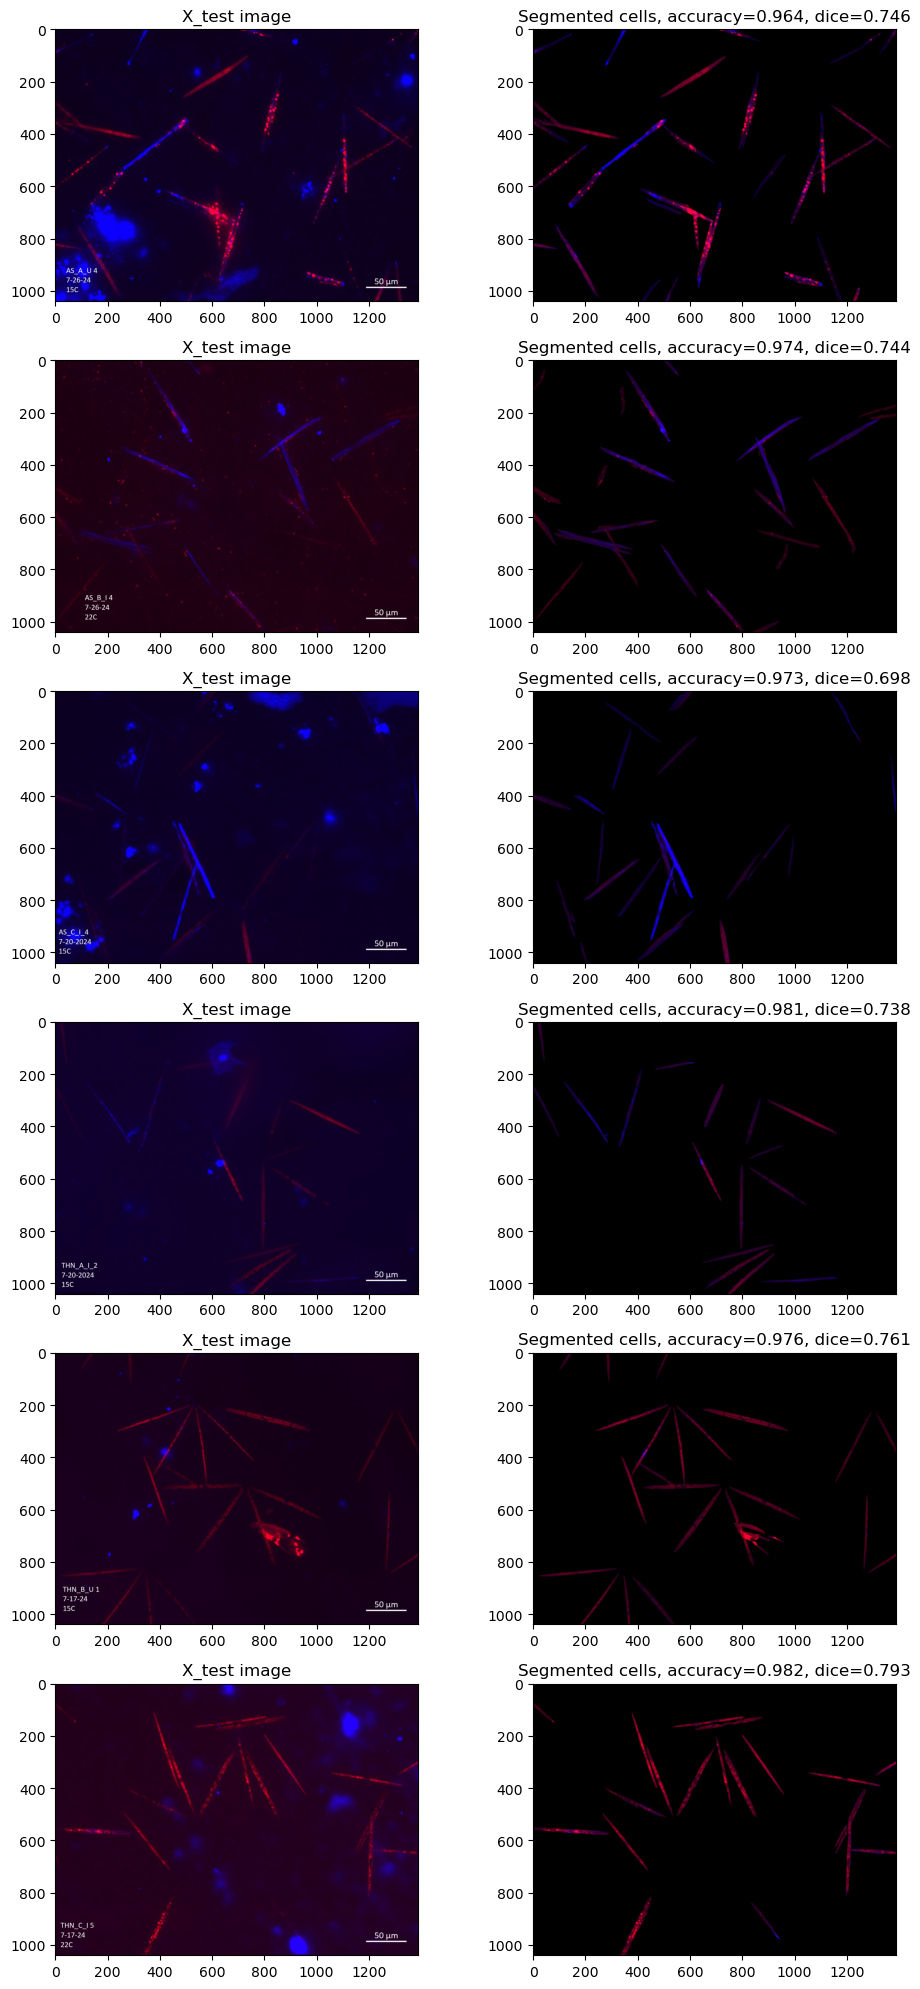

In [96]:
#Just for fun show we can output the clean images with background removed

fig, ax = plt.subplots(6, 2, figsize=(10, 20))
for i in range(len(X)):
    
    coordinates_to_blobs,blob_sizes,clean_prediction=remove_tiny_blobs(test_predictions[i]) 
    clean_image=np.copy(X[i])
    for x in range(len(X[i])):
        for y in range(len(X[i][0])):
            if clean_prediction[x,y]==0:
                clean_image[x,y,0]=0
                clean_image[x,y,1]=0
                clean_image[x,y,2]=0
    ax[i,0].imshow(X[i], cmap='magma')
    ax[i,1].imshow(clean_image, cmap='magma')
    ax[i,0].set_title("X_test image")
    ax[i,1].set_title(f"Segmented cells, accuracy={round(accuracies[i],3)}, dice={round(dice_scores[i],3)}")
fig.tight_layout()

In [97]:
fig.savefig("ML_output/images/test_set_background_removal.png")